In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import maria

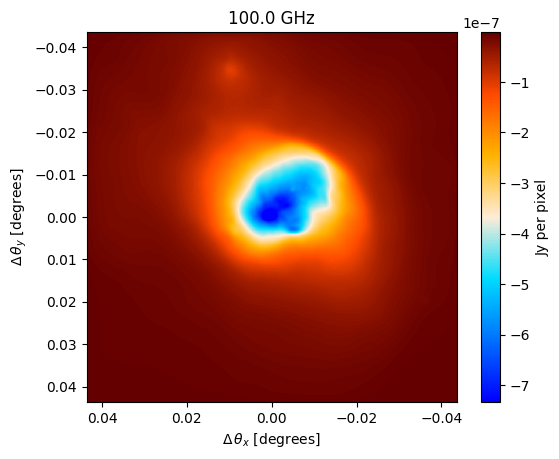

In [18]:
map_filename = maria.io.fetch("maps/cluster.fits")
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

# map_filename = maria.io.fetch("maps/big_cluster.fits")
# input_map = maria.map.read_fits(filename=map_filename, 
#                                 width=1., #degrees
#                                 index=1,
#                                 center=(300.0, -10.0), #RA and Dec in degrees
#                                 units ='Jy/pixel'
#                                )

input_map.plot()

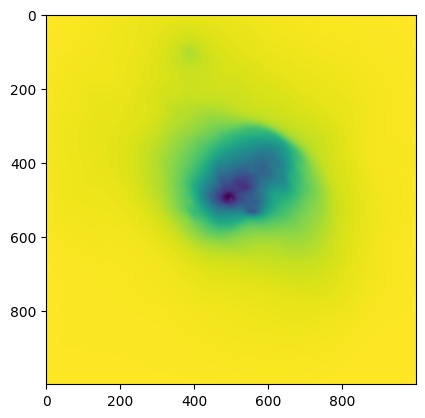

In [22]:
plt.imshow(input_map.data[0].T)

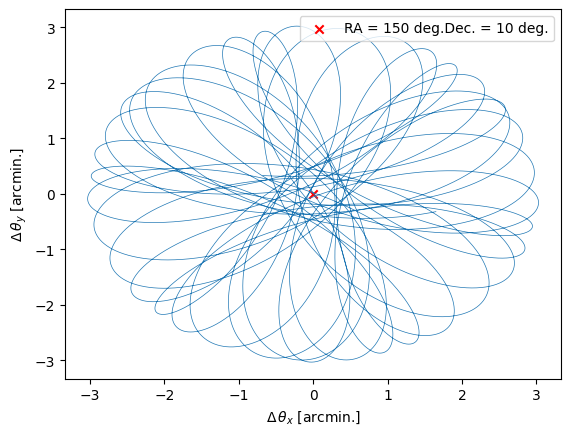

In [4]:
# MUSTANG:
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

# ATLAST:
# plan = maria.get_plan(scan_pattern="daisy",
#                       scan_options={"radius": 0.25, "speed": 0.5}, # in degrees
#                       duration=60, # in seconds
#                       sample_rate=225, # in Hz
#                       start_time = "2022-08-10T06:00:00",
#                       scan_center=(300.0, -10.0),
#                       frame="ra_dec")

plan.plot()

In [5]:
# MUSTANG:
instrument = maria.get_instrument('MUSTANG-2')

#ATLAST
# from maria.instrument import Band

# f090 = Band(center=92, # in GHz
#             width=40.0,
#             knee=1,
#             sensitivity=6e-5) # in K sqrt(s)

# array = {"field_of_view": 1.0, "bands": [f090]}
# instrument = maria.get_instrument(array=array, primary_size=50, beam_spacing = 2)

# instrument.plot()

In [6]:
sim = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       noise=False,
                    #    atmosphere="2d",
                    #    cmb="generate",
                    #    cmb_kwargs={"nside": 8192},
                      )

tod = sim.run()

tod

2024-07-24 10:10:53.508 INFO: Constructed instrument.
2024-07-24 10:10:53.509 INFO: Constructed plan.
2024-07-24 10:10:53.510 INFO: Constructed site.
2024-07-24 10:10:54.068 INFO: Constructed boresight.
2024-07-24 10:10:54.322 INFO: Constructed offsets.


Initialized base in 814 ms.


Sampling map (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


TOD(shape=(217, 30000), fields=['map'])

In [7]:
sim.coords.offsets(frame=sim.map.frame, center=sim.map.center)

(dask.array<real, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>,
 dask.array<neg, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>)

In [8]:
time = tod.time.compute()

data = tod.data.compute()
# cmb = tod.components['cmb'].compute()
# atmosphere = tod.components['atmosphere'].compute()
mapdata = tod.components['map'].compute()

In [9]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

cmb_cmap = plt.get_cmap('cmb')

In [10]:
dx, dy = sim.coords.offsets(frame=sim.map.frame, center=sim.map.center)

# dx = dx.compute()
# dy = dy.compute()

Making plot for timestep: 0 0.0 %


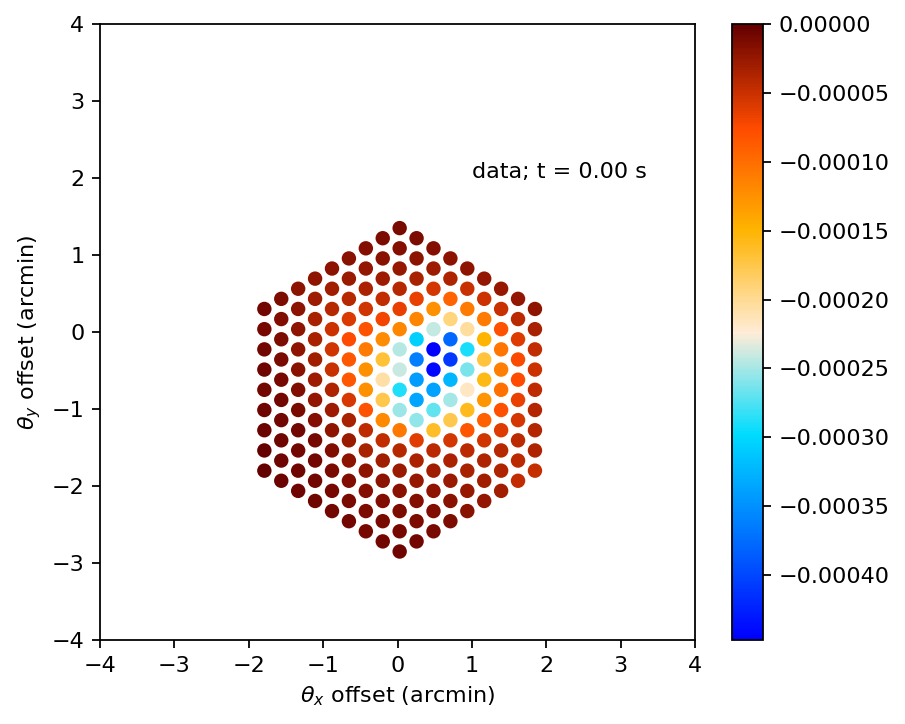

In [11]:
from matplotlib.collections import EllipseCollection
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
# import matplotlib.cm as cm

from maria.tod.coords import Angle


def plot_time(instrument, data, addtext= "data", timestep=0, tmax=None):
        HEX_CODE_LIST = [
            mpl.colors.to_hex(mpl.colormaps.get_cmap("Paired")(t))
            for t in [*np.linspace(0.05, 0.95, 12)]
        ]

        if tmax is None:
            tmax = data.shape[1]
        print(f"Making plot for timestep: {timestep} {(timestep/tmax*100):.1f} %")

        fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=160)
        # fig, ax = plt.subplots(1, 1)

        fwhms = Angle(instrument.fwhm)
        offsets = Angle(instrument.offsets)

        for iub, uband in enumerate(instrument.ubands):
            band_mask = instrument.dets.band_name == uband

            band_color = HEX_CODE_LIST[iub]

            # print("HERE:", getattr(offsets, offsets.units)[band_mask].shape)

            # move detectors by offset:
            x, y = getattr(offsets, offsets.units)[band_mask].T
            dx, dy = 60. * np.degrees(plan.scan_offsets_radians)

            # invert dy
            dy = -1*dy

            # rotate by angle:
            theta = 2.*np.pi * ((66.)/360.)
            xrot = np.cos(theta)*dx - np.sin(theta)*dy
            yrot = np.sin(theta)*dx + np.cos(theta)*dy
            dx = xrot
            dy = yrot

            # if plotting only part of detector modules
            # x = x[:10]
            # y = y[:10]

            x = np.broadcast_to(x, (dx.size,x.size)).T
            y = np.broadcast_to(y, (dy.size,y.size)).T
            
            # x = np.broadcast_to(x, (dx.shape[1],x.size)).T
            # y = np.broadcast_to(y, (dy.shape[1],y.size)).T

            xzero = x[0]
            yzero = y[0]

            x = x+dx
            y = y+dy

            # print("OTHER:", x[:, timestep].shape)
            # print("BOOYA", np.stack((x[:, timestep], y[:, timestep]), axis=1).shape)
    
            # norm = mcolors.Normalize(vmin=np.min(data[:,timestep]), vmax=np.max(data[:,timestep]))
            # atmos_color = cmb_cmap(norm(data[:,timestep]))
            # ellipses = EllipseCollection(
            #         widths=getattr(fwhms, offsets.units)[band_mask],
            #         heights=getattr(fwhms, offsets.units)[band_mask],
            #         angles=0,
            #         units="xy",
            #         # facecolors=band_color,
            #         facecolors=atmos_color,
            #         edgecolors="face",
            #         lw=1e-1,
            #         # alpha=0.5,
            #         # offsets=getattr(offsets, offsets.units)[band_mask],
            #         offsets=np.stack((x[:, timestep], y[:, timestep]), axis=1),
            #         transOffset=ax.transData,
            #         cmap=cmb_cmap,
            #     )
            # ax.add_collection(ellipses)

            im = ax.scatter(
                x[:, timestep], 
                y[:, timestep],
                label=uband,
                s=30, # for MUSTANG
                # s=0.5, # for ATLAST
                c=data[:,timestep],
                # c=data[:10,timestep],
                cmap=cmb_cmap
            )

            plt.plot((xzero+dx)[:timestep], (yzero+dy)[:timestep], linewidth=1)

        fig.colorbar(im)
        ax.set_xlabel(rf"$\theta_x$ offset ({offsets.units})")
        ax.set_ylabel(rf"$\theta_y$ offset ({offsets.units})")

        xls, yls = ax.get_xlim(), ax.get_ylim()
        cen_x, cen_y = np.mean(xls), np.mean(yls)
        wid_x, wid_y = np.ptp(xls), np.ptp(yls)
        radius = 0.5 * np.maximum(wid_x, wid_y)

        # ax.set_xlim(cen_x - radius, cen_x + radius)
        # ax.set_ylim(cen_y - radius, cen_y + radius)
        # MUSTANG
        ax.set_xlim(-4., 4.)
        ax.set_ylim(-4., 4.)
        # ATLAST
        # ax.set_xlim(-40., 40.)
        # ax.set_ylim(-40., 40.)

        plt.text(1., 2., f"{addtext}; t = {time[timestep]:.2f} s") # For MUSTANG
        # plt.text(10, 30., f"{addtext}; t = {time[timestep]:.2f} s") # For ATLAST
        
        # plt.show()
        return fig
        
fig = plot_time(instrument, mapdata, timestep=0)
# fig = plot_time(instrument, mapdata, timestep=299)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import io


# Generate and capture individual frames
num_frames = data.shape[1]//3
# num_frames = 3000
nskip = num_frames//30

print("num_frames", num_frames)

def makegif(dataarr, label):

    # Create a list to hold the frames
    frames = []

    for i in range(0, num_frames, nskip):
        
        fig = plot_time(instrument, dataarr, timestep=i, addtext=label, tmax=num_frames)
        
        # Capture the plot as an image in memory
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        
        # Create an image from the buffer
        buf.seek(0)
        img = Image.open(buf)
        frames.append(img)

    # Save the frames as a GIF
    # frames[0].save('testgif_atmosphere.gif', save_all=True, append_images=frames[1:], duration=1, loop=0)
    frames[0].save(f'{label}_offsets.gif', save_all=True, append_images=frames[1:], duration=10, loop=0)

num_frames 10000


In [13]:
makegif(mapdata, label="map")

Making plot for timestep: 0 0.0 %


Making plot for timestep: 333 3.3 %
Making plot for timestep: 666 6.7 %
Making plot for timestep: 999 10.0 %
Making plot for timestep: 1332 13.3 %
Making plot for timestep: 1665 16.7 %
Making plot for timestep: 1998 20.0 %
Making plot for timestep: 2331 23.3 %
Making plot for timestep: 2664 26.6 %
Making plot for timestep: 2997 30.0 %
Making plot for timestep: 3330 33.3 %
Making plot for timestep: 3663 36.6 %
Making plot for timestep: 3996 40.0 %
Making plot for timestep: 4329 43.3 %
Making plot for timestep: 4662 46.6 %
Making plot for timestep: 4995 50.0 %
Making plot for timestep: 5328 53.3 %
Making plot for timestep: 5661 56.6 %
Making plot for timestep: 5994 59.9 %
Making plot for timestep: 6327 63.3 %
Making plot for timestep: 6660 66.6 %
Making plot for timestep: 6993 69.9 %
Making plot for timestep: 7326 73.3 %
Making plot for timestep: 7659 76.6 %
Making plot for timestep: 7992 79.9 %
Making plot for timestep: 8325 83.2 %
Making plot for timestep: 8658 86.6 %
Making plot for t

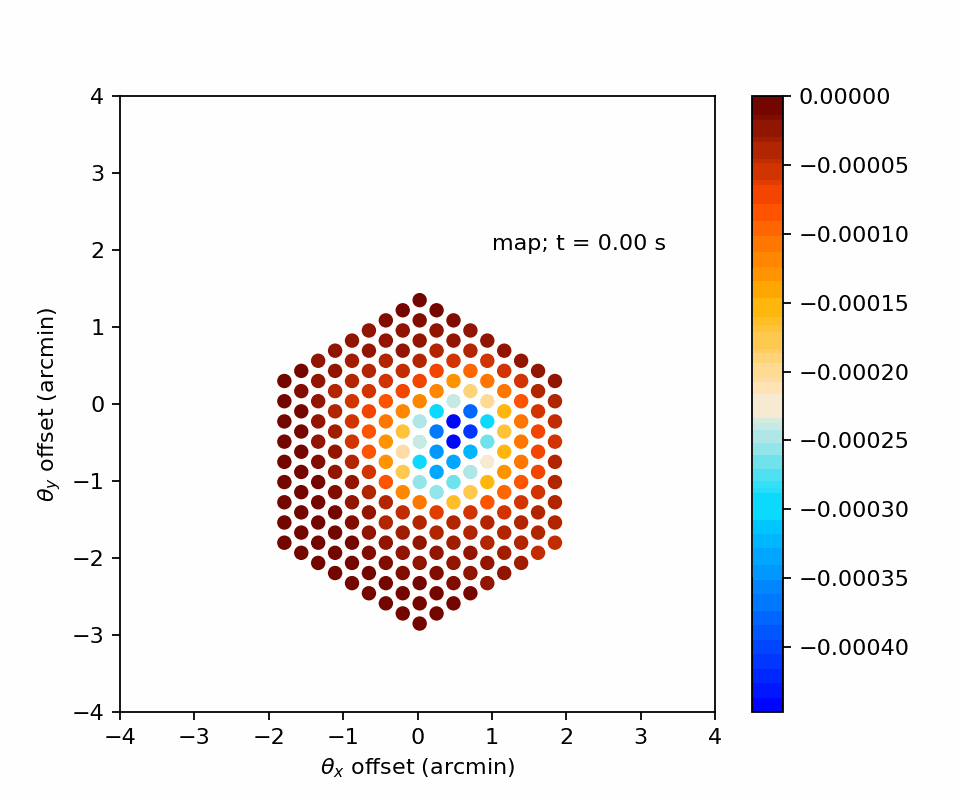

In [14]:
from IPython.display import Image as IPImage, display

display(IPImage(open('map_offsets.gif', 'rb').read()))

## Constructing a time-dependent mask

Idea: 
- make ismasked(x,y)->bool fn
- extend to average over all vals in one ellipse 

In [15]:
from matplotlib.collections import EllipseCollection
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
# import matplotlib.cm as cm

from maria.tod.coords import Angle


def is_seen(theta_x, theta_y, instrument, data, timestep=0, tmax=None):

        if tmax is None:
            tmax = data.shape[1]
        # print(f"Getting mask for timestep: {timestep} {(timestep/tmax*100):.1f} %")

        fwhms = Angle(instrument.fwhm)
        offsets = Angle(instrument.offsets)

        for iub, uband in enumerate(instrument.ubands):
            band_mask = instrument.dets.band_name == uband

            # move detectors by offset:
            x, y = getattr(offsets, offsets.units)[band_mask].T
            dx, dy = 60. * np.degrees(plan.scan_offsets_radians)

            # invert dy
            dy = -1*dy

            # rotate by angle:
            theta = 2.*np.pi * ((66.)/360.)
            xrot = np.cos(theta)*dx - np.sin(theta)*dy
            yrot = np.sin(theta)*dx + np.cos(theta)*dy
            dx = xrot
            dy = yrot

            # if plotting only part of detector modules
            # x = x[:10]
            # y = y[:10]

            x = np.broadcast_to(x, (dx.size,x.size)).T
            y = np.broadcast_to(y, (dy.size,y.size)).T

            x = x+dx
            y = y+dy

            width=getattr(fwhms, offsets.units)[band_mask][0]
            
            x = x[:, timestep]
            y = y[:, timestep]
            
            x = np.broadcast_to(x, (theta_x.size, x.size))
            y = np.broadcast_to(y, (theta_y.size, y.size))
            
            theta_x = theta_x[:, np.newaxis]
            theta_y = theta_y[:, np.newaxis]
            
            distsqrd = (x - theta_x)**2 + (y - theta_y)**2

        return np.any(distsqrd <= (width/2.)**2, axis=1)
        
is_seen(np.array([0., 4.544]), np.array([0., 8.077620112807255]), instrument, mapdata, timestep=0)

array([ True, False])

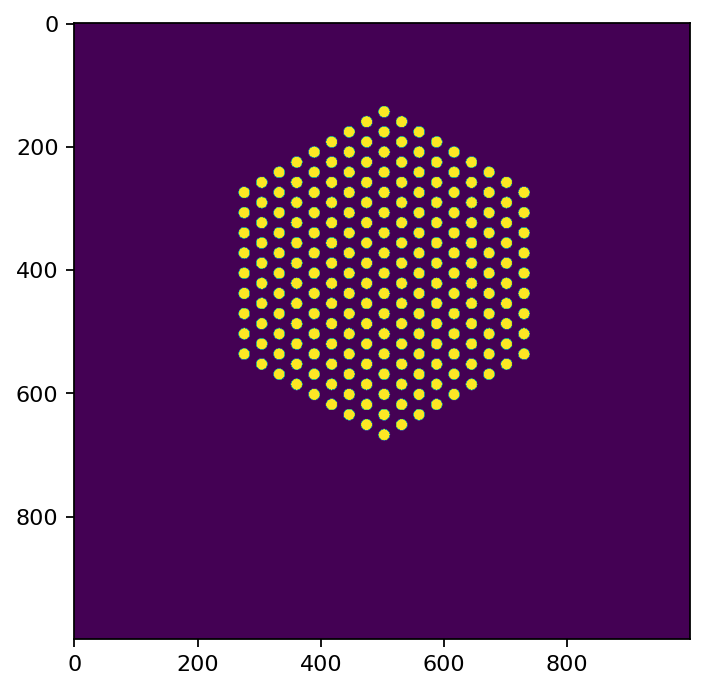

In [16]:
npix = 1000

# ATLAST
xvals = np.linspace(-4., 4., npix)
yvals = np.linspace(-4., 4., npix)
# ATLAST
# xvals = np.linspace(-40., 40., npix)
# yvals = np.linspace(-40., 40., npix)
xv, yv = np.meshgrid(xvals, yvals)

xv = xv.flatten()
yv = yv.flatten()

zvals = is_seen(xv, yv, instrument, mapdata, timestep=0)

zvals = zvals.reshape(npix, npix)

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=160)
ax.imshow(zvals)

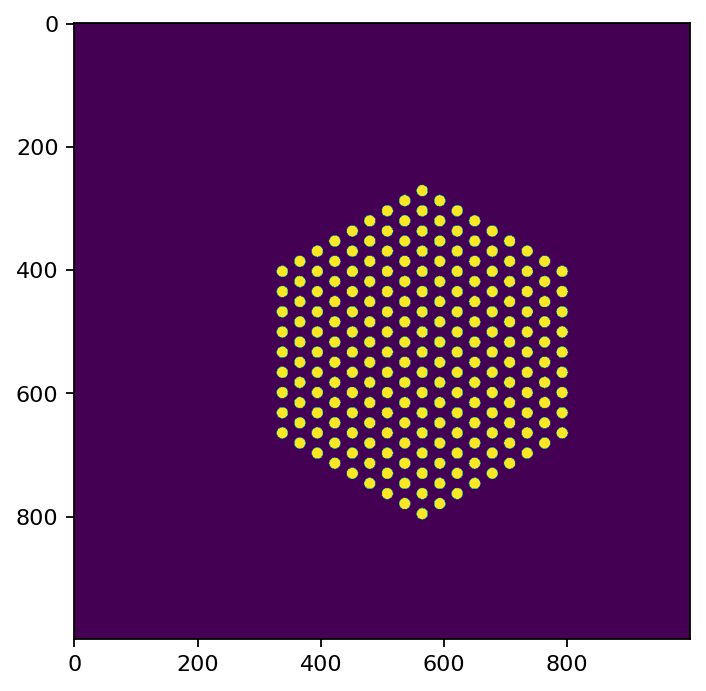

In [17]:
zvals = is_seen(xv, yv, instrument, mapdata, timestep=100)

zvals = zvals.reshape(npix, npix)

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=160)
ax.imshow(zvals)

### Next: add averaging for everything inside detector I!

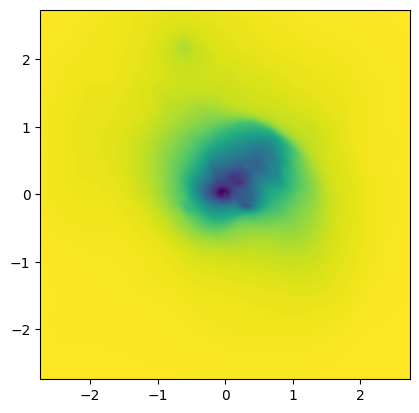

In [35]:
map_width = -input_map.width/2*60**2
map_height = -input_map.height/2*60**2

true_map = input_map.data[0].T

plt.imshow(true_map, extent=[-map_width, map_width, -map_height, map_height])

zmask shape (1000, 1000)
true_map shape (1000, 1000)


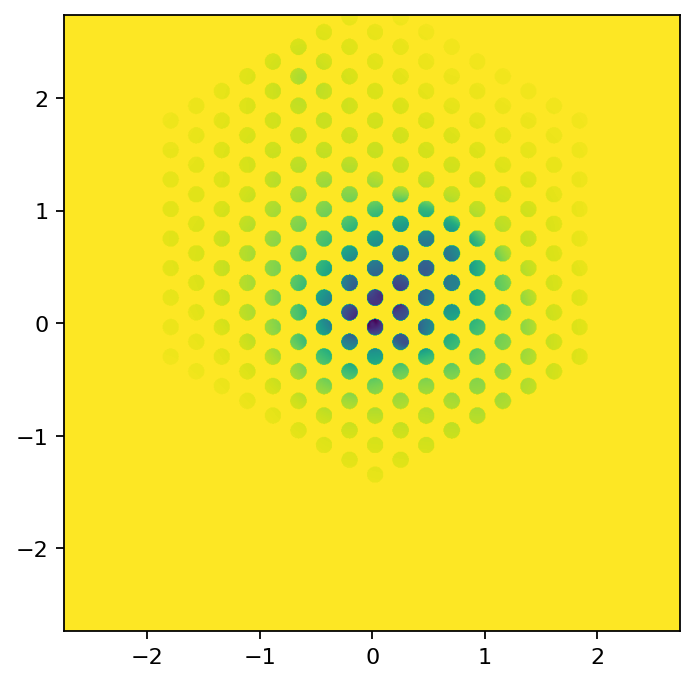

In [45]:
xvals = np.linspace(-map_width, map_width, input_map.data[0].T.shape[0])
yvals = np.linspace(-map_height, map_height, input_map.data[0].T.shape[1])

xv, yv = np.meshgrid(xvals, yvals)

xv = xv.flatten()
yv = yv.flatten()

zmask = is_seen(xv, yv, instrument, mapdata, timestep=0)

zmask = zmask.reshape(input_map.data[0].T.shape)

print("zmask shape", zmask.shape)
print("true_map shape", true_map.shape)

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=160)
# ax.imshow(zmask, extent=[-map_width, map_width, -map_height, map_height])
ax.imshow(np.where(zmask, true_map, 0), extent=[-map_width, map_width, -map_height, map_height])